Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 11, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

$f$ is periodic if $\exists k: f(x) = f(x + k)$ where $k$ is the period.

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

* Amplitude: height of local maximum. Change by multiplying a factor to the function
* Wavelength: length of a period, i.e. the distance between points on the graph with the same value
* Frequency: Inverse of wavelength

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

See previous sheet.

## Assignment 1: Multiscale representation [8 Points]

**a)** What is a *scale space*? What is a multiscale representation? What is the motivation for a multiscale strategy in the context of segmentation?

Scale space is the space spanned by high-dimensional vectors subsampled with a real-valued factor to obtain lower-resolution versions. 

*Problem*

The problem is that segmentation without multiscale considerations is subject to strong fluctuations, even if the image changes only slightly. 

**b)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

The gaussian pyramid is built from an image by gaussian filtering and subsequent subsampling by a factor of two. This continues as long as possible. The set of filtered and downsampled images forms the pyramid. 

`reduce` works by first convolving $I_k$ with a gaussian kernel and then subsampling (could be averaging, or simply selecting one out of four pixels?) to obtain $I_{k+1}$.

A low-pass filter lets only the low frequencies of a signal pass (hence the name) while filtering out the high ones. In an image, this means removing small details while preserving larger gradients. The gaussian filter is one example of such a filter.

Apparently, according to the Nyquist Sampling Theorem, a signal must be sampled at at least twice the highest frequency in the signal in order for the original to be reconstructible by interpolation (in an information-theoretic sense). Thus we remove the highest frequencies in the image before subsampling as otherwise, artifacts might occur due to too small a subsampling frequency.

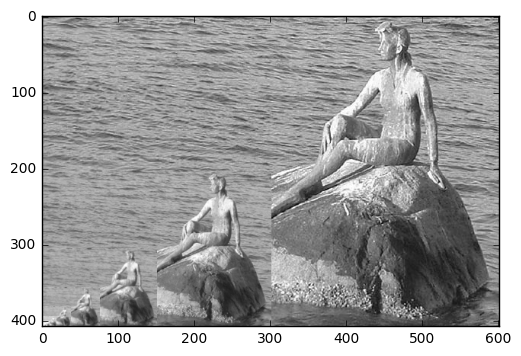

In [2]:
import numpy as np
from scipy import misc
from scipy.ndimage.filters import convolve, convolve1d
import matplotlib.pyplot as plt

img = misc.imread('mermaid.png', mode='F')

pyramid_image = img
h, w = img.shape

filter1d_down = 1/16 * np.array([1,4,6,4,1])
kernel = np.outer(filter1d_down, filter1d_down)
plt.gray()

def reduce(img):
    current_level = convolve(img, kernel)
    return 255 * current_level[::2,::2] / current_level.max()
    
reduced_levels = []
current_level = img
while True:
    current_level = reduce(current_level)
    if current_level.size < 4:
        break
    reduced_levels.append(current_level.copy())
    pyramid_image[-current_level.shape[0]:,:current_level.shape[1]] = current_level


plt.imshow(pyramid_image)
plt.show()


**c)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

Expansion upsamples the image by a factor of two, interpolating between the original's pixels. I don't know how this works.

`reduce` can't simply be inverted since information is thrown aways by smoothing and downsampling.

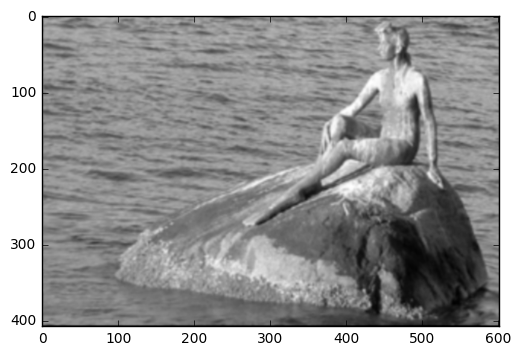

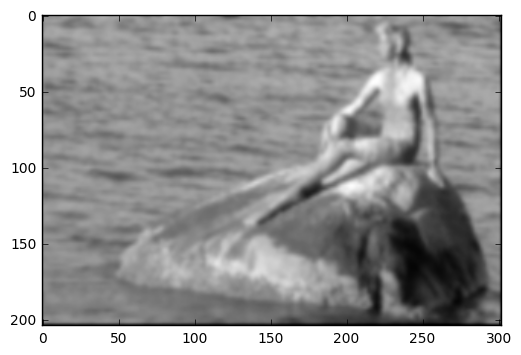

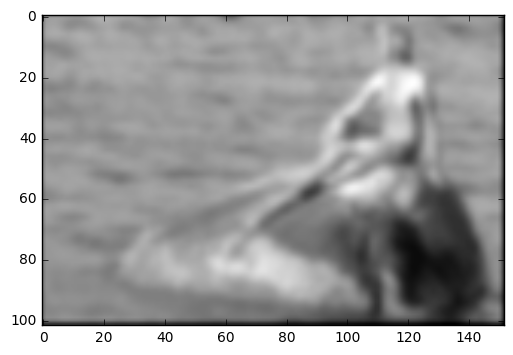

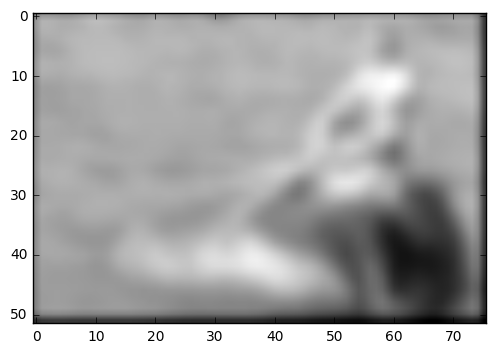

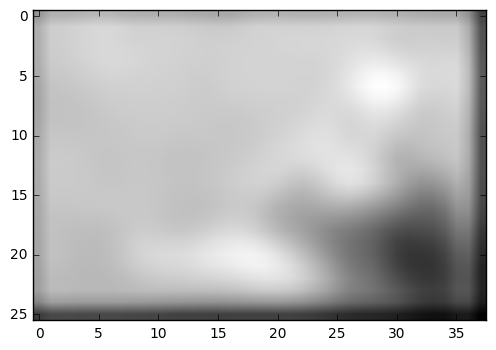

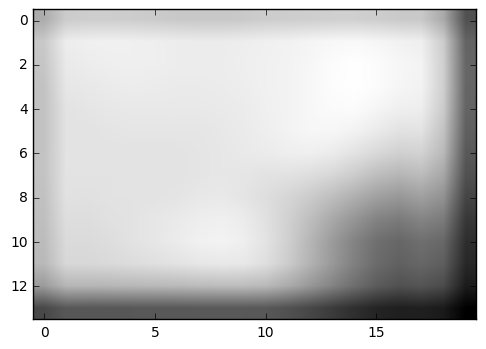

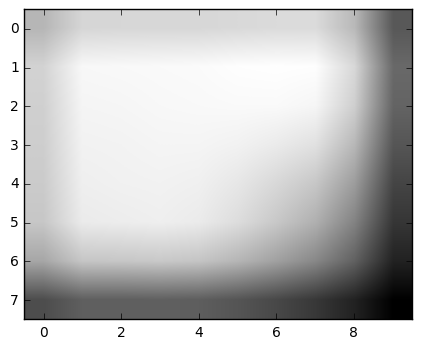

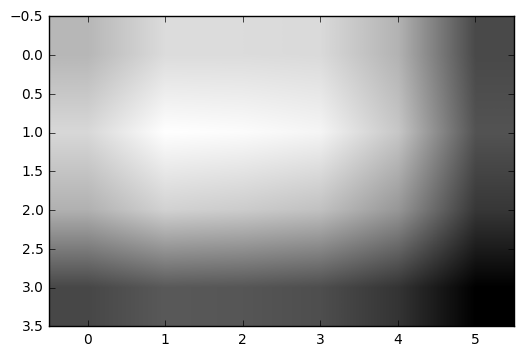

In [3]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

def expand(img, new_size=None):
    # This is what opencv pyrUp does. No idea how to do it myself. 
    # Quote: "The function performs the upsampling step of the 
    # Gaussian pyramid construction, though it can actually 
    # be used to construct the Laplacian pyramid. First, it 
    # upsamples the source image by injecting even zero rows 
    # and columns and then convolves the result with the same 
    # kernel as in pyrDown() multiplied by 4."
    new_size = new_size or (2*img.shape[0], 2*img.shape[1])
    image_up = np.zeros(new_size) # odd number of rows or cols will get rounded
    # down during reduce. Here we simply make the output as big as desired,
    # hopefully no one will notice
    image_up[::2, ::2] = img
    return convolve(image_up, 4 * kernel, mode='constant')


img = misc.imread('mermaid.png', mode='F')

for image in reduced_levels:
    plt.imshow(expand(image))
    plt.show()

**d)** What is the *Laplacian pyramid*? What is it used for? Compute the Laplacian pyramid and generate an image similar to the one on (CV-07 slide 36).

The laplacian pyramid is what is obtained from the gaussian pyramig if the `expand`ed version of level $i+1$ is subtracted from level $i$.

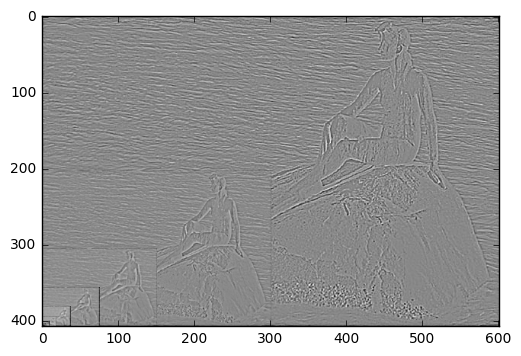

In [4]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img = misc.imread('mermaid.png', mode='F')

pyramid_image = img
current_level = img
while True:
    sz = current_level.shape
    reduced = reduce(current_level)
    expanded = expand(reduced, new_size=sz)
    if current_level.size < 4:
        break
    pyramid_image[-current_level.shape[0]:,:current_level.shape[1]] = expanded - current_level
    current_level = reduced

plt.imshow(pyramid_image)
plt.show()


## Assignment 2: Texture Segmentation [6 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

Texture is a term for the colour and relief pattern of an image, invariant of transformations such as scaling, warping or illumination changes. While easy for humans to identify, images with the same texture can be hard to correlate for a computer since the low-level features strongly change with the illumination or transformation of the image. Therefore it is doubtful whether this can be used for successful segmentation without further information.

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

A co-occurrence matrix is parametrised by an angle $\alpha$, a distance $d$ and technically an image patch/region $W$. For each pair of gray values, it contains the sum over all pixels in the patch which have the first gray value and a "neighbour" pixel in direction $\alpha$ at distance $d$ with the second gray value. The sum is normalised via division with the number of pixels in the patch.

**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

In [ ]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img = misc.imread('mermaid.png', mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


from itertools import product
def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    matrix = np.zeros((256,256))
    h, w = img.shape
    assert (dx, dy) != (0, 0), "Directional vector cannot be zero length."

    # first we computed index array to shave off the pixels which cannot have
    # neihbours in the given direction at the given distance
    if dx > 0 and dy > 0:
        indices = (np.arange(0, h-dx), np.arange(0, w-dy))
        indices_shift = (np.arange(dx, h), np.arange(dy, w))
    elif dx == 0 and dy > 0:
        indices = (np.arange(0, h), np.arange(0, w-dy))
        indices_shift = (np.arange(0, h), np.arange(dy, w))
    elif dx > 0 and dy == 0:
        indices = (np.arange(0, h-dx), np.arange(0, w))
        indices_shift = (np.arange(dx, h), np.arange(0, w))
    elif dx == 0 and dy < 0:
        indices = (np.arange(0, h), np.arange(-dy, w))
        indices_shift = (np.arange(0, h), np.arange(0, w-dy))
    elif dx < 0 and dy == 0:
        indices = (np.arange(-dx, h), np.arange(0, w))
        indices_shift = (np.arange(0, h-dx), np.arange(0, w))
    elif dx < 0 and dy < 0:
        indices = (np.arange(-dx, h), np.arange(-dy, w))
        indices_shift = (np.arange(0, h+dx), np.arange(0, w+dy))
    else:
        raise Exception("I can't deal with this situation.")

    def delta(arr):
        return arr == 0

    # we only need to loop over the values which actually occur in the patch
    for (g1, g2) in product(np.arange(img.min(), img.max()+1), np.arange(img.min(), img.max()+1)):

        # apparently, using integer arrays as indices is different from slices,
        # for some unknown reason. Dunno what it does, but np.ix_ yields arrays
        # that do what you would expect
        patch_g1 = delta(img[np.ix_(*indices)] - g1)
        patch_g2 = delta(img[np.ix_(*indices_shift)] - g2)

        # patch_g1.size == patch_g2.size
        matrix[g1, g2] = 1/patch_g1.size * (patch_g1 * patch_g2).sum()

    return matrix


# plt.figure(figsize=(12, 12))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(12, 12))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    plt.subplot(len(patches),3,i+2); plt.imshow(cooccurrence(p,1,0))
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence(p,0,1))
    i += 3
plt.show()


## Assignment 3: Region merging [6 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

In [ ]:
# FIXME: put your code here!
